In [49]:
#Python Warning off
import warnings
warnings.filterwarnings('ignore')

#TF warning off
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [50]:
# LSTM 삼성전자 주식 예측 

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 

In [52]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [53]:
df_raw = pd.read_csv('datasets/01-삼성전자-주가.csv', encoding = 'utf-8')

In [54]:
df_raw

,일자,시가,고가,저가,종가,거래량
0,20200107,55700,56400,55600,55800,9893846
1,20200106,54900,55600,54600,55500,10278951
2,20200103,56000,56600,54900,55500,15422255
3,20200102,55500,56000,55000,55200,12993228
4,20191230,56200,56600,55700,55800,8356767
...,...,...,...,...,...,...
9283,19850109,126,126,122,123,324836
9284,19850108,129,129,127,127,845098
9285,19850107,129,130,128,129,771895
9286,19850105,129,129,128,128,108496


In [55]:
df_raw.describe()

,일자,시가,고가,저가,종가,거래량
count,9.288000e+03,9288.000000,9288.000000,9288.000000,9288.000000,9.288000e+03
mean,2.001347e+07,11108.556417,11228.754522,10986.106481,11108.235465,1.645823e+07
std,1.015376e+05,13792.646300,13920.105135,13658.809496,13790.922497,1.701535e+07
min,1.985010e+07,116.000000,116.000000,115.000000,116.000000,0.000000e+00
25%,1.992121e+07,624.000000,632.000000,620.000000,623.000000,3.833986e+06
50%,2.001032e+07,5045.000000,5190.000000,4955.000000,5075.000000,1.199608e+07
75%,2.010080e+07,15920.000000,16050.000000,15740.000000,15920.000000,2.284080e+07
max,2.020011e+07,57500.000000,57520.000000,56760.000000,57220.000000,3.266220e+08


In [56]:
df_raw['일자'] = pd.to_datetime(df_raw['일자'], format='%Y%m%d')

In [57]:
df_raw['연도'] = df_raw['일자'].dt.year
df_raw['월'] = df_raw['일자'].dt.month
df_raw['일'] = df_raw['일자'].dt.day

In [58]:
df_raw
# Wow ... 

,일자,시가,고가,저가,종가,거래량,연도,월,일
0,2020-01-07,55700,56400,55600,55800,9893846,2020,1,7
1,2020-01-06,54900,55600,54600,55500,10278951,2020,1,6
2,2020-01-03,56000,56600,54900,55500,15422255,2020,1,3
3,2020-01-02,55500,56000,55000,55200,12993228,2020,1,2
4,2019-12-30,56200,56600,55700,55800,8356767,2019,12,30
...,...,...,...,...,...,...,...,...,...
9283,1985-01-09,126,126,122,123,324836,1985,1,9
9284,1985-01-08,129,129,127,127,845098,1985,1,8
9285,1985-01-07,129,130,128,129,771895,1985,1,7
9286,1985-01-05,129,129,128,128,108496,1985,1,5


In [59]:
### 1990년 이후 데이터만  써보자 

In [60]:
df1 = df_raw.loc[df_raw['연도'] >= 1990]

In [61]:
df1

,일자,시가,고가,저가,종가,거래량,연도,월,일
0,2020-01-07,55700,56400,55600,55800,9893846,2020,1,7
1,2020-01-06,54900,55600,54600,55500,10278951,2020,1,6
2,2020-01-03,56000,56600,54900,55500,15422255,2020,1,3
3,2020-01-02,55500,56000,55000,55200,12993228,2020,1,2
4,2019-12-30,56200,56600,55700,55800,8356767,2019,12,30
...,...,...,...,...,...,...,...,...,...
7823,1990-01-08,681,687,673,673,966666,1990,1,8
7824,1990-01-06,685,689,681,681,1724183,1990,1,6
7825,1990-01-05,689,693,678,678,1790849,1990,1,5
7826,1990-01-04,689,701,685,693,2738562,1990,1,4


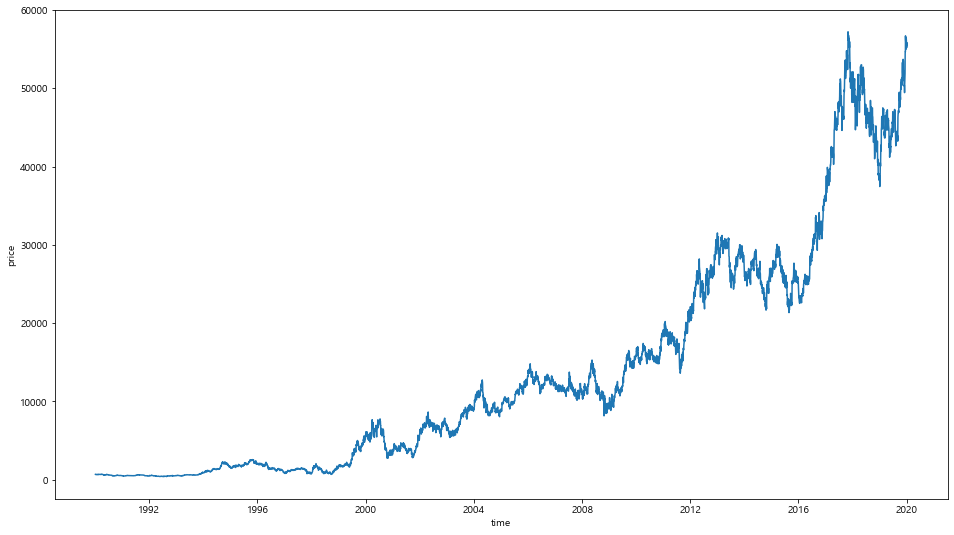

In [62]:
plt.figure(figsize = (16,9))
sns.lineplot(x=df1['일자'],y=df1['종가'])
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [63]:
# 정렬 

In [64]:
df = df1.sort_index(ascending=False).reset_index(drop=True) #내림차순??
df

,일자,시가,고가,저가,종가,거래량,연도,월,일
0,1990-01-03,673,689,661,685,1715032,1990,1,3
1,1990-01-04,689,701,685,693,2738562,1990,1,4
2,1990-01-05,689,693,678,678,1790849,1990,1,5
3,1990-01-06,685,689,681,681,1724183,1990,1,6
4,1990-01-08,681,687,673,673,966666,1990,1,8
...,...,...,...,...,...,...,...,...,...
7823,2019-12-30,56200,56600,55700,55800,8356767,2019,12,30
7824,2020-01-02,55500,56000,55000,55200,12993228,2020,1,2
7825,2020-01-03,56000,56600,54900,55500,15422255,2020,1,3
7826,2020-01-06,54900,55600,54600,55500,10278951,2020,1,6


In [65]:
from sklearn.preprocessing import MinMaxScaler

In [66]:
scaler = MinMaxScaler()

In [67]:
scale_cols = ['시가', '고가', '저가', '종가', '거래량'] # 선택적 Scaling 방식
scaled_arr = scaler.fit_transform(df[scale_cols])

In [68]:
df_scaled = pd.DataFrame(scaled_arr, columns=scale_cols) #array와 데이터 프레임은 다르다. array 는 numpy 객체, df 는 pandas 객체 

In [69]:
df_scaled

,시가,고가,저가,종가,거래량
0,0.004955,0.005129,0.004860,0.005138,0.005251
1,0.005236,0.005339,0.005286,0.005279,0.008384
2,0.005236,0.005199,0.005162,0.005015,0.005483
3,0.005165,0.005129,0.005215,0.005068,0.005279
4,0.005095,0.005094,0.005073,0.004927,0.002960
...,...,...,...,...,...
7823,0.977237,0.983895,0.981197,0.975012,0.025585
7824,0.964980,0.973391,0.968779,0.964454,0.039781
7825,0.973735,0.983895,0.967005,0.969733,0.047217
7826,0.954474,0.966389,0.961684,0.969733,0.031470


In [70]:
TEST_SIZE = 200

In [71]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [72]:
#20일(window_size=20) 데이터를 묶어서 처리하는ㅎ 함수 
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size])) # index location
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list) # numpy array로 변환해서 리턴

In [73]:
feature_cols = ['시가', '고가', '저가', '거래량'] #X
label_cols = ['종가']#Y

In [74]:
train_feature ,train_label = make_dataset(train[feature_cols], train[label_cols], 20)

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
x_train, x_valid, y_train, y_valid = train_test_split(
    train_feature, train_label, test_size=0.2) #20% 밸리데이션 

In [77]:
x_train.shape, x_valid.shape

((6086, 20, 4), (1522, 20, 4))

In [78]:
len(x_train)

6086

In [79]:
test_feature, test_label = make_dataset(test[feature_cols], test[label_cols], 20)

In [80]:
test_feature.shape, test_label.shape

((180, 20, 4), (180, 1))

In [81]:
####### preprocessing end
#  model 설계 시작 


In [82]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM

In [83]:
model = Sequential()

In [84]:
model.add(LSTM(16, activation='relu', input_shape={train_feature.shape[1], train_feature.shape[2]})) #20,4 input
model.add(Dense(1))

In [85]:
model.compile(loss='mse', optimizer='adam')

In [87]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [88]:
check_point = ModelCheckpoint("lstm_samsung_cp.h5", verbose=1, save_best_only=True)

In [89]:
%%time
hist = model.fit(x_train, y_train, epochs=200, batch_size=16, validation_data=(x_valid,y_valid), callbacks=[early_stop, check_point])

Train on 6086 samples, validate on 1522 samples
Epoch 1/200
6086/6086 [==============================] - 4s 589us/step - loss: 0.0070 - val_loss: 9.0419e-05

Epoch 00001: val_loss improved from inf to 0.00009, saving model to lstm_samsung_cp.h5
Epoch 2/200
6086/6086 [==============================] - 3s 488us/step - loss: 8.4702e-05 - val_loss: 1.0126e-04

Epoch 00002: val_loss did not improve from 0.00009
Epoch 3/200
6086/6086 [==============================] - 3s 481us/step - loss: 8.1929e-05 - val_loss: 8.5547e-05

Epoch 00003: val_loss improved from 0.00009 to 0.00009, saving model to lstm_samsung_cp.h5
Epoch 4/200
6086/6086 [==============================] - 3s 491us/step - loss: 7.6491e-05 - val_loss: 7.0619e-05

Epoch 00004: val_loss improved from 0.00009 to 0.00007, saving model to lstm_samsung_cp.h5
Epoch 5/200
6086/6086 [==============================] - 3s 487us/step - loss: 7.0671e-05 - val_loss: 9.1531e-05

Epoch 00005: val_loss did not improve from 0.00007
Epoch 6/200
608

In [91]:
pred = model.predict(test_feature)
pred

array([[0.81611973],
       [0.81629395],
       [0.8185079 ],
       [0.807158  ],
       [0.79212826],
       [0.78757036],
       [0.78283554],
       [0.7796593 ],
       [0.7713242 ],
       [0.7680276 ],
       [0.7864506 ],
       [0.7933913 ],
       [0.7911673 ],
       [0.79085255],
       [0.7785308 ],
       [0.77030486],
       [0.7537563 ],
       [0.74332637],
       [0.739216  ],
       [0.7276073 ],
       [0.7389512 ],
       [0.72717905],
       [0.7200071 ],
       [0.72283053],
       [0.74243444],
       [0.7476593 ],
       [0.7549444 ],
       [0.74889463],
       [0.738563  ],
       [0.7356349 ],
       [0.7227304 ],
       [0.7313973 ],
       [0.7345396 ],
       [0.7452986 ],
       [0.7497635 ],
       [0.759244  ],
       [0.75792295],
       [0.7669511 ],
       [0.7735686 ],
       [0.7730709 ],
       [0.76163393],
       [0.75706667],
       [0.7565219 ],
       [0.7609667 ],
       [0.78157127],
       [0.7805598 ],
       [0.78735083],
       [0.786

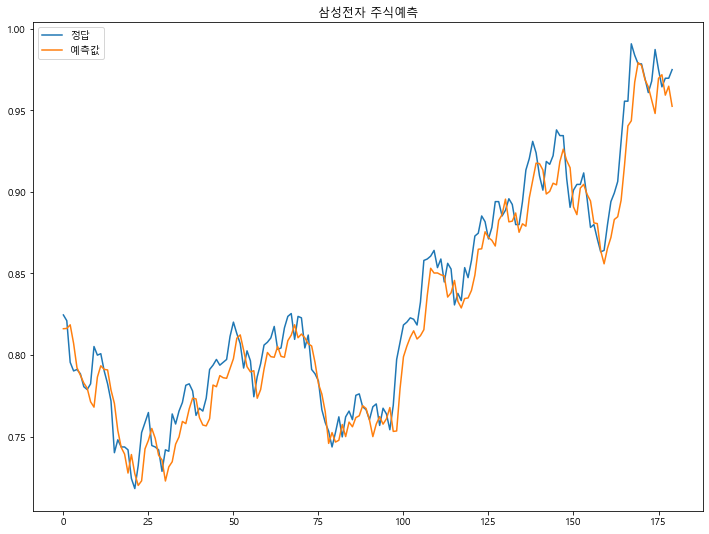

In [94]:
plt.figure(figsize=(12,9))
plt.title('삼성전자 주식예측')
plt.plot(test_label,label='정답')
plt.plot(pred, label='예측값')
plt.legend()
plt.show()